In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def swap_id_or_name(target, path='data/Homo_sapiens_mapping.csv'):
    db_frame = pd.read_csv(path, sep=',')
    try:
        assert any(db_frame.label == target)
        return db_frame[(db_frame['label'] == target)]['gene_symbol'].values[0]
    except AssertionError:
        try:
            return db_frame[(db_frame['gene_symbol'] == target)]['label'].values[0]
        except IndexError:
            return 'NO GENE FOUND'
    except IndexError:
        return 'NO GENE FOUND'

In [3]:
def align_by_id(target, path='data/Homo_sapiens_mapping.csv'):
    db_frame = pd.read_csv(path, sep=',')
    try:
        assert any(db_frame.label == target)
        return target
    except AssertionError:
        try:
            return db_frame[(db_frame['gene_symbol'] == target)]['label'].values[0]
        except IndexError:
            return 'NO GENE FOUND'
    except IndexError:
        return 'NO GENE FOUND'

In [4]:
def get_expr_list(expressions, gene, tissue):
    # expressions - список дата фреймов
    # gene - искомое имя
    # tissue - ткань 
    expr_list = []
    for i in range(len(expressions)):
        try:
            expr_list += list(expressions[i].T[tissue].loc[gene])
        except Exception:
            continue
    
    return expr_list

In [5]:
orthologs = pd.read_csv('data/ortbase.csv', sep='\t')

hum2mouse = {}
mouse2human = {}

for i in range(orthologs.shape[0]):
    
    if orthologs.iloc[i, 0] not in hum2mouse.keys():
        hum2mouse[orthologs.iloc[i, 0]] = [orthologs.iloc[i, 1]]
    else:
        hum2mouse[orthologs.iloc[i, 0]].append(orthologs.iloc[i, 1])
        
    if orthologs.iloc[i, 1] not in mouse2human.keys():
        mouse2human[orthologs.iloc[i, 1]] = [orthologs.iloc[i, 0]]
    else:
        mouse2human[orthologs.iloc[i, 1]].append(orthologs.iloc[i, 0])

def find_orthologs(gene_id):
    
    if gene_id in hum2mouse.keys():
        return hum2mouse[gene_id]
    elif gene_id in mouse2human.keys():
        return mouse2human[gene_id]
    else:
        return 'NO GENE FOUND'

In [6]:
gene_human = pd.read_csv('data/h_slux.txt', sep='\n')['Gene Name'].values
gene_mouse = pd.read_csv('data/m_slux.txt', sep='\n')['Gene Name'].values

In [7]:
gene_human

array(['SLC1A3', 'SLITRK6', 'NEUROG1', 'DRD2', 'TIFAB', 'DCANP1'],
      dtype=object)

In [8]:
gene_mouse

array(['Slc1a3', 'Drd2', 'Tifab', 'Slitrk6', 'Neurog1'], dtype=object)

In [9]:
gene_mouse.sort()
gene_human.sort()

In [10]:
gene_human = gene_human.tolist()

In [11]:
gene_human.remove('DCANP1')
gene_human.append('DCANP1')
gene_human = np.array(gene_human)

In [12]:
orth_gene_human = []
for elem in gene_human:
    orth_gene_human.append(find_orthologs(align_by_id(elem)))

In [13]:
for elem in orth_gene_human:
    if elem == 'NO GENE FOUND':
        pass
    elif len(elem) == 1:
        elem[0] = swap_id_or_name(elem[0], path='data/Mus_musculus_mapping.csv')
    else:
        for i in range(len(elem)):
            elem[i] = swap_id_or_name(elem[i], path='data/Mus_musculus_mapping.csv')

In [14]:
orth_gene_mouse = []
for elem in gene_mouse:
    orth_gene_mouse.append(find_orthologs(align_by_id(elem, path='data/Mus_musculus_mapping.csv')))

In [15]:
for elem in orth_gene_mouse:
    if elem == 'NO GENE FOUND':
        pass
    elif len(elem) == 1:
        elem[0] = swap_id_or_name(elem[0])
    else:
        for i in range(len(elem)):
            elem[i] = swap_id_or_name(elem[i])

In [16]:
orth_counter_mouse = []
for elem in orth_gene_mouse:
    if len(elem) == 1:
        orth_counter_mouse.append(gene_human.tolist().count(elem[0]))
    else:
        counter = 0
        for i in range(len(elem)):
            counter += gene_human.tolist().count(elem[0])
        orth_counter_mouse.append(counter)

In [17]:
orth_counter_human = []
for elem in orth_gene_human:
    if len(elem) == 1:
        orth_counter_human.append(gene_mouse.tolist().count(elem[0]))
    else:
        counter = 0
        for i in range(len(elem)):
            counter += gene_mouse.tolist().count(elem[0])
        orth_counter_human.append(counter)

In [18]:
mypath_to_mouse = 'data/datasets_mouse_corrected/'
onlyfiles_mouse = [f for f in os.listdir(mypath_to_mouse) if os.path.isfile(os.path.join(mypath_to_mouse, f))]

In [19]:
mypath_to_human = 'data/datasets_human_corrected/'
onlyfiles_human = [f for f in os.listdir(mypath_to_human) if os.path.isfile(os.path.join(mypath_to_human, f))]

In [20]:
human_set_keeper = []
for elem in onlyfiles_human:
    human_set_keeper.append(pd.read_csv(mypath_to_human + elem, sep='\t').set_index('Tissue'))

In [21]:
mouse_set_keeper = []
for elem in onlyfiles_mouse:
    mouse_set_keeper.append(pd.read_csv(mypath_to_mouse + elem, sep='\t').set_index('Tissue'))

In [22]:
human_data = []
for elem in gene_human:
    human_data.append(np.array(get_expr_list(human_set_keeper, elem, 'Nervous System')).mean())

In [23]:
mouse_data = []
for elem in gene_mouse:
    mouse_data.append(np.array(get_expr_list(mouse_set_keeper, elem, 'Nervous System')).mean())

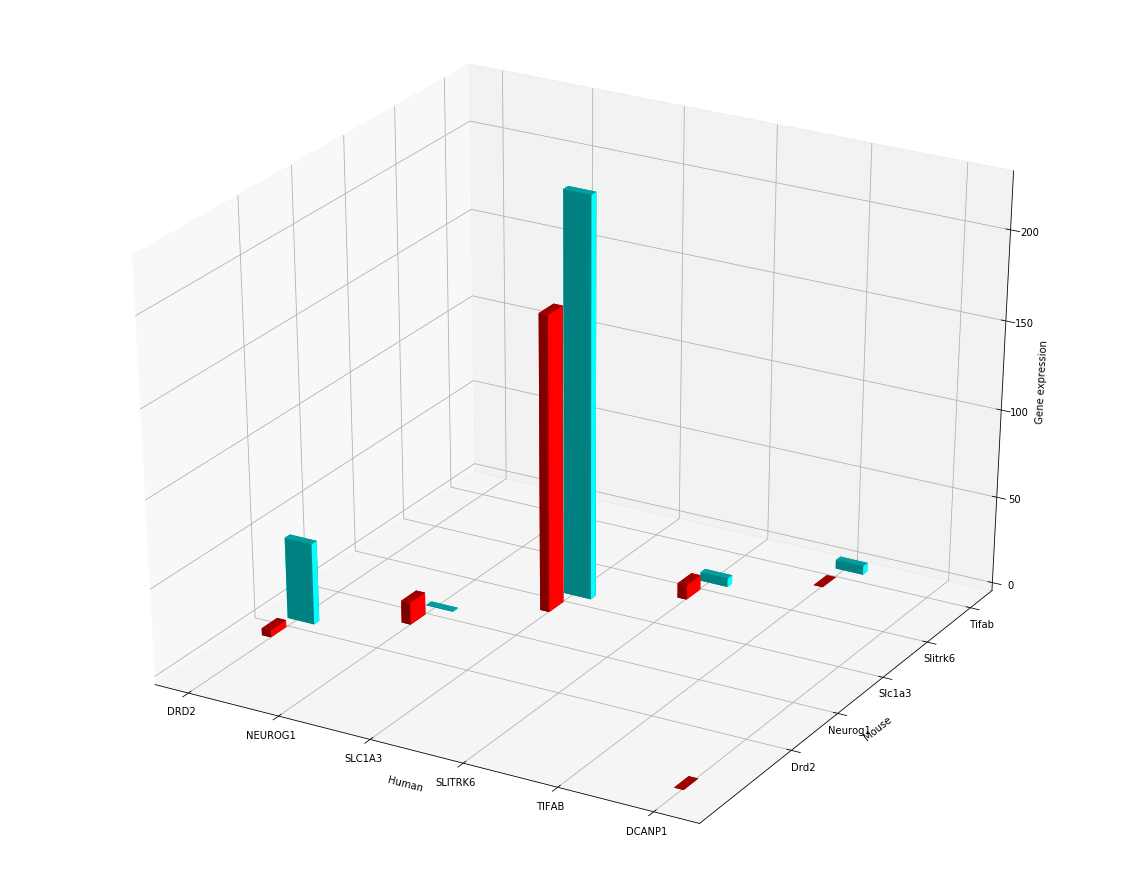

In [24]:
fig = plt.figure(figsize=(20, 16))
ax1 = fig.add_subplot(111, projection='3d')

ax1.bar3d(np.arange(1, len(gene_human) + 1), 
          [x if orth_counter_human[x-1] != 0 else 0 for x in range(1, len(gene_human) + 1)],
          np.zeros(len(gene_human)),
          dx = 0.1, 
          dy = 0.3, 
          dz = human_data,
          color='r', shade=True, label='human')

ax1.bar3d([x if orth_counter_mouse[x-1] != 0 else 0 for x in range(1, len(gene_mouse) + 1)], 
          np.arange(1, len(gene_mouse) + 1) + 0.5,
          np.zeros(len(gene_mouse)),
          dx = 0.3, 
          dy = 0.1, 
          dz = mouse_data,
          color='cyan', shade=True, label='mouse')

ax1.set_xlabel('Human')
ax1.set_ylabel('Mouse')
ax1.set_zlabel('Gene expression')

plt.xticks(np.arange(1, len(gene_human) + 1), gene_human)
plt.yticks(np.arange(1, len(gene_mouse) + 1) + 0.5, gene_mouse)

plt.show()